# **CLIP Explainability**

In [37]:
!git clone https://github.com/hila-chefer/Transformer-MM-Explainability

import os
os.chdir(f'./Transformer-MM-Explainability')

!pip install einops
!pip install ftfy
!pip install captum
!pip install regex
!pip install opencv-python
!pip install -r requirements.txt

fatal: destination path 'Transformer-MM-Explainability' already exists and is not an empty directory.
  Using cached einops-0.3.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached imageio-2.9.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached matplotlib-3.3.2.tar.gz (37.9 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached numpy-1.19.2.zip (7.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... error
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [54 lines of output]
      Running from numpy source directory.
      setup.py:470: UserWarning: Unrecognized setuptools command, proceeding with generating Cython sources and expanding templates
        run_build = parse_setuppy_comm

# **CLIP**

In [38]:
import sys
sys.path.append('./Transformer-MM-Explainability')
import torch
from CLIP import clip
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from captum.attr import visualization

In [39]:
#@title Control context expansion (number of attention layers to consider)
#@title Number of layers for image Transformer
start_layer =  -1#@param {type:"number"}

#@title Number of layers for text Transformer
start_layer_text =  -1#@param {type:"number"}

In [40]:
def interpret(image, texts, model, device, start_layer=start_layer, start_layer_text=start_layer_text, is_multiple_prompts=False):
    if is_multiple_prompts:
      batch_size = 2
      images = image.repeat(batch_size, 1, 1, 1)

      text_features = model.encode_text(texts)
      text_features = torch.cat([text_features[0:len(text_features)//2].mean(dim=0, keepdim=True), text_features[len(text_features)//2:].mean(dim=0, keepdim=True)], dim=0)
      text_features = text_features / text_features.norm(dim=-1, keepdim=True)

      images_features = model.encode_image(images)
      images_features = images_features / images_features.norm(dim=-1, keepdim=True)

      logits_per_image = (100.0 * images_features @ text_features.T).softmax( dim=-1)
    else:
      batch_size = texts.shape[0]
      images = image.repeat(batch_size, 1, 1, 1)
      logits_per_image, _ = model(images, texts)
    
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())

    if start_layer == -1:
      # calculate index of last layer
      start_layer = len(image_attn_blocks) - 1

    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(image_attn_blocks):
        if i < start_layer:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R = R + torch.bmm(cam, R)
    image_relevance = R[:, 0, 1:]


    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())

    if start_layer_text == -1:
      # calculate index of last layer
      start_layer_text = len(text_attn_blocks) - 1

    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(text_attn_blocks):
        if i < start_layer_text:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R_text = R_text + torch.bmm(cam, R_text)
    text_relevance = R_text

    return text_relevance, image_relevance

In [41]:
def get_image_relevance(image_relevance):
    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()

    return image_relevance

In [42]:
def plot_img_heatmap(orig_image, image_relevance):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    #image = orig_image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (orig_image - orig_image.min()) / (orig_image.max() - orig_image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)

    _, axs = plt.subplots(1, 2)
    axs[0].imshow(image)
    axs[0].axis('off')

    axs[1].imshow(vis)
    axs[1].axis('off')

In [43]:
from CLIP.clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
_tokenizer = _Tokenizer()

def show_heatmap_on_text(text, text_encoding, R_text):
  CLS_idx = text_encoding.argmax(dim=-1)
  R_text = R_text[CLS_idx, 1:CLS_idx]
  text_scores = R_text / R_text.sum()
  text_scores = text_scores.flatten()
  print(text_scores)
  text_tokens=_tokenizer.encode(text)
  text_tokens_decoded=[_tokenizer.decode([a]) for a in text_tokens]
  vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,text_tokens_decoded,1)]
  visualization.visualize_text(vis_data_records)

In [ ]:
clip.clip._MODELS = {
    "ViT-L/14": "https://openaipublic.azureedge.net/clip/models/b8cca3fd41ae0c99ba7e8951adf17d267cdb84cd88be6f7c2e0eca1737a03836/ViT-L-14.pt",
}

In [45]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _ = clip.load("ViT-L/14", device=device, jit=False)

In [46]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [ ]:
templates_gender = [
    'male {}.',
    'female {}.',
]

In [48]:
from torchvision import transforms

INPUT_SIZE = 224
PRE__MEAN = [0.48145466, 0.4578275, 0.40821073]
PRE__STD = [0.26862954, 0.26130258, 0.27577711]

transform = transforms.Compose([
    transforms.Resize([INPUT_SIZE, INPUT_SIZE]),            # Resize to model input size (optional, adjust as needed)
    transforms.ToTensor(),                    # Convert PIL image to PyTorch tensor
    transforms.Normalize(mean=PRE__MEAN, std=PRE__STD)  # Normalize
])

morphing_prompts = ["face image morphing attack."]
bonafide_prompts = ["bona-fide presentation."]

texts = morphing_prompts + bonafide_prompts
text = clip.tokenize(texts).to(device)

batch_size = text.shape[0]
root_folder = '/data/mcaldeir/FaceMAD/evaluate_MAD/'

In [49]:
def get_average_heatmaps(data_folder, text, is_multiple_prompts=False):
    img_names = os.listdir(data_folder)
    real_num_imgs = 0
    image_relevance = []
    avg_img = None

    for img_name in img_names:
        if not (".png" in img_name or ".jpeg" in img_name or ".jpg" in img_name):
            continue

        real_num_imgs += 1

        img_path = os.path.join(data_folder, img_name)
        img = transform(Image.open(img_path)).unsqueeze(0).to(device)
        _, R_image = interpret(model=model, image=img, texts=text, device=device, is_multiple_prompts=is_multiple_prompts)

        for i in range(batch_size):
            if len(image_relevance) < i + 1:
                image_relevance.append(get_image_relevance(R_image[i]))
            else:
                image_relevance[i] += get_image_relevance(R_image[i])

        if avg_img is None:
            avg_img = img.clone()
        else:
            avg_img += img

    avg_img = avg_img / real_num_imgs
    avg_img = avg_img.detach().cpu().squeeze(0).permute(1, 2, 0).numpy()

    for i in range(len(image_relevance)):
        image_relevance[i] = image_relevance[i] / real_num_imgs

    norm_image_relevance = []
    for i in range(len(image_relevance)):  
        plot_img_heatmap(avg_img, image_relevance[i]) 
        norm_image_relevance.append((image_relevance[i] - image_relevance[i].min()) / (image_relevance[i].max() - image_relevance[i].min()))

    stacked_relevance = torch.stack([torch.from_numpy(r) if isinstance(r, np.ndarray) else r for r in norm_image_relevance])
    heatmap_norms = stacked_relevance.norm(p=2, dim=(1, 2))

    heatmap_diff = (norm_image_relevance[0] - norm_image_relevance[1])**2
    diff_value = heatmap_diff.mean()

    return heatmap_norms, diff_value

(tensor([44.4062, 31.8125], dtype=torch.float16), 0.005783)

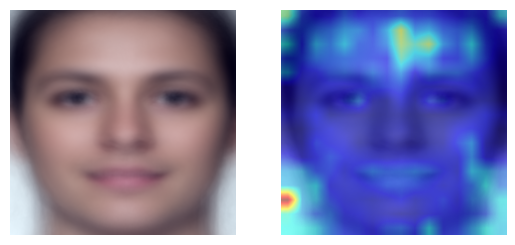

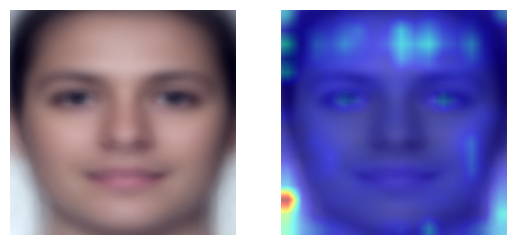

In [50]:
extra_folder = 'bonafide'
get_average_heatmaps(root_folder + extra_folder, text)

(tensor([57.6920, 41.5545]), 0.019736277)

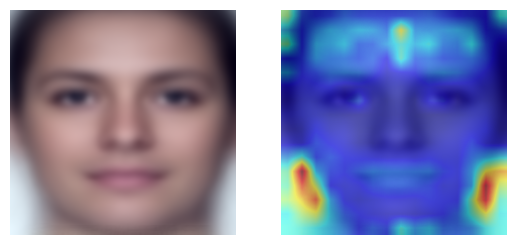

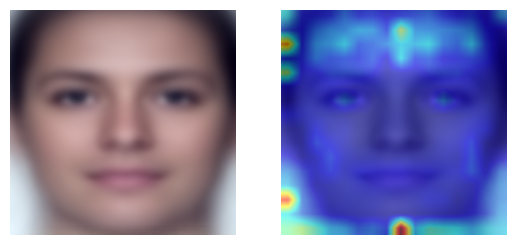

In [51]:
extra_folder = 'FaceMorpher'
get_average_heatmaps(root_folder + extra_folder, text)

(tensor([37.6513, 24.3483]), 0.0055148634)

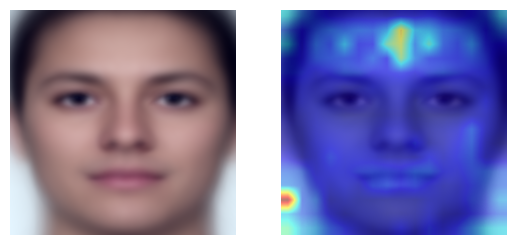

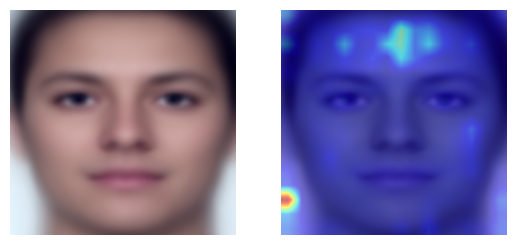

In [52]:
extra_folder = 'MIPGAN_I'
get_average_heatmaps(root_folder + extra_folder, text)

(tensor([41.6426, 24.4878]), 0.0086561935)

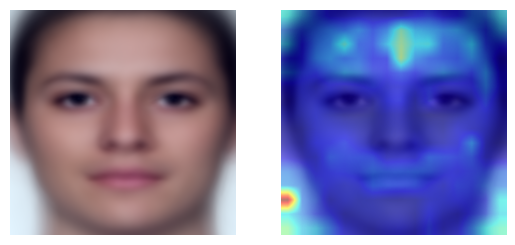

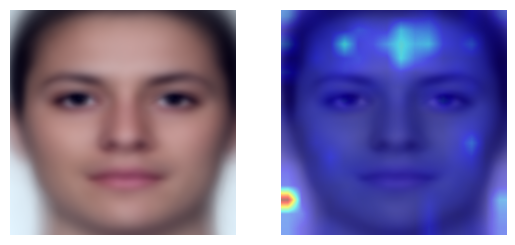

In [53]:
extra_folder = 'MIPGAN_II'
get_average_heatmaps(root_folder + extra_folder, text)

(tensor([64.3381, 47.5915]), 0.012946255)

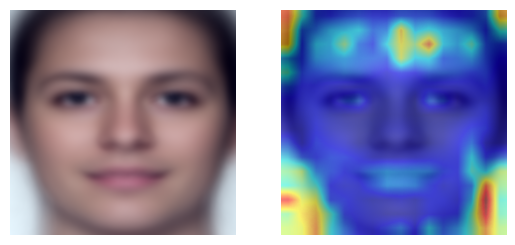

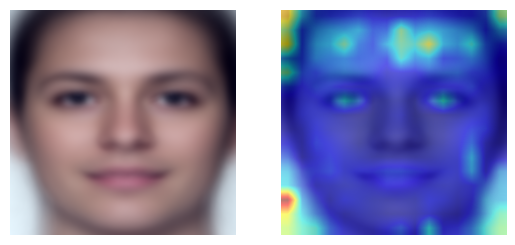

In [54]:
extra_folder = 'OpenCV'
get_average_heatmaps(root_folder + extra_folder, text)

(tensor([67.7709, 50.1782]), 0.01241284)

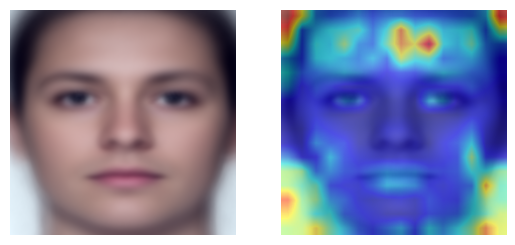

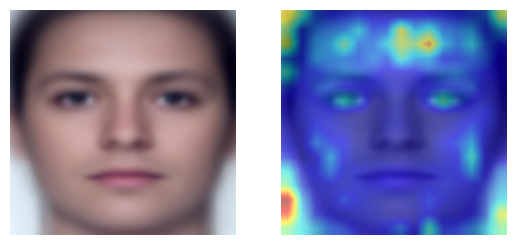

In [55]:
extra_folder = 'Webmorph'
get_average_heatmaps(root_folder + extra_folder, text)

Morphing norm:  65.27045440673828
Bonafide norm:  37.01266098022461
Heatmap differences:  0.028262105


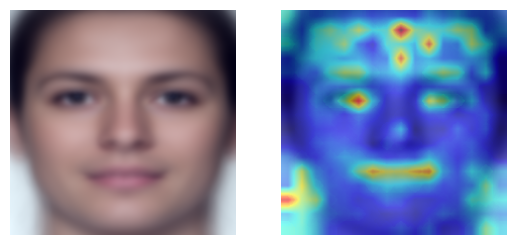

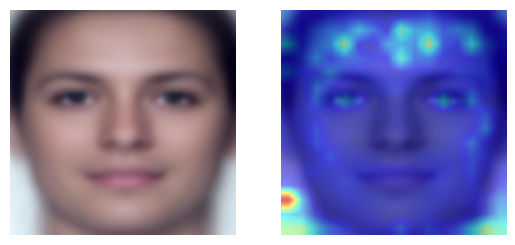

In [56]:
extra_folder = 'MorDIFF_all_imgs'
heatmap_norms, diff_value = get_average_heatmaps(root_folder + extra_folder, text, is_multiple_prompts=True)
print("Morphing norm: ", heatmap_norms[0].item())
print("Bonafide norm: ", heatmap_norms[1].item())
print("Heatmap differences: ", diff_value)

In [57]:
templates_id = [
    'male {}.',
    'female {}.',
    'young {}.',
    'elderly {}.',
    'child {}.',
    'adult {}.',
    'asian {}.',
    'black {}.',
    'white {}.',
    'latino {}.',
    'middle eastern {}.',
    'indian {}.',
    'blonde {}.',
    'brunette {}.',
    'redhead {}.',
    'tall {}.',
    'short {}.',
    'thin {}.',
    'obese {}.',
    'teen {}.',
]

templates_presentation = [
    'frontal {}.',
    'profile {}.',
    'tilted {}.',
    'rotated {}.',
    'upward {}.',
    'downward {}.',
    'sideways {}.',
    'leftward {}.',
    'rightward {}.',
    'angled {}.',
    'inclined {}.',
    'declined {}.',
    'oblique {}.',
    'twisted {}.',
    'turned {}.',
    'slanted {}.',
    'offcenter {}.',
    'misaligned {}.',
    'skewed {}.',
    'asymmetric {}.',
]

templates_appearance = [
    'bearded {}.',
    'moustached {}.',
    'smiling {}.',
    'frowning {}.',
    'eyeglasses {}.',
    'sunglasses {}.',
    'wrinkled {}.',
    'balding {}.',
    'occluded {}.',
    'scarred {}.',
    'pierced {}.',
    'tanned {}.',
    'pale {}.',
    'makeup {}.',
    'freckled {}.',
    'chubby-cheeked {}.',
    'sweaty {}.',
    'dirty {}.',
    'blinking {}.',
    'tearful {}.',
]

templates_id_pr = templates_id + templates_presentation
templates_id_ap = templates_id + templates_appearance
templates_pr_ap = templates_presentation + templates_appearance
templates_all = templates_id + templates_presentation + templates_appearance

In [ ]:
extra_folder = 'OpenCV'

Morphing norm:  58.893001556396484
Bonafide norm:  20.35610008239746
Heatmap differences:  0.03950882


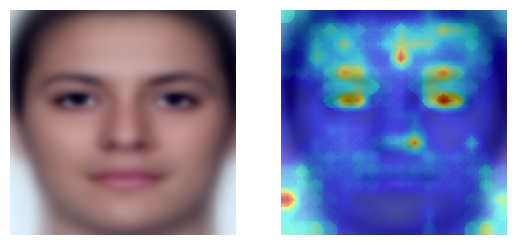

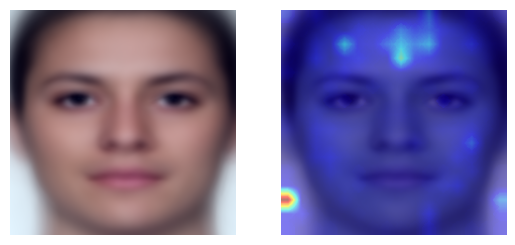

In [74]:
morphing_prompts = [template.format("face image morphing attack") for template in templates_id]
bonafide_prompts = [template.format("bona-fide presentation") for template in templates_id]

texts = morphing_prompts + bonafide_prompts
text = clip.tokenize(texts).to(device)

heatmap_norms, diff_value = get_average_heatmaps(root_folder + extra_folder, text, is_multiple_prompts=True)
print("Morphing norm: ", heatmap_norms[0].item())
print("Bonafide norm: ", heatmap_norms[1].item())
print("Heatmap differences: ", diff_value)

Morphing norm:  52.948055267333984
Bonafide norm:  20.699893951416016
Heatmap differences:  0.027809009


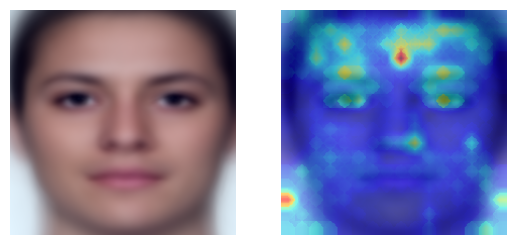

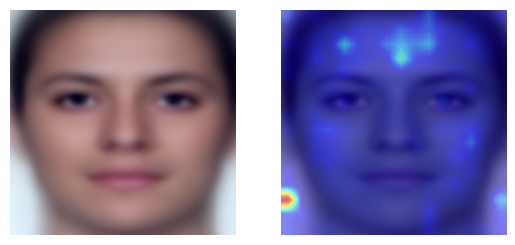

In [75]:
morphing_prompts = [template.format("face image morphing attack") for template in templates_presentation]
bonafide_prompts = [template.format("bona-fide presentation") for template in templates_presentation]

texts = morphing_prompts + bonafide_prompts
text = clip.tokenize(texts).to(device)

heatmap_norms, diff_value = get_average_heatmaps(root_folder + extra_folder, text, is_multiple_prompts=True)
print("Morphing norm: ", heatmap_norms[0].item())
print("Bonafide norm: ", heatmap_norms[1].item())
print("Heatmap differences: ", diff_value)

Morphing norm:  78.65483093261719
Bonafide norm:  26.18362045288086
Heatmap differences:  0.06529292


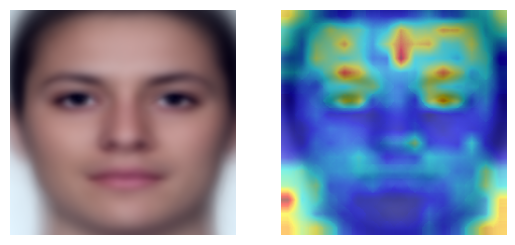

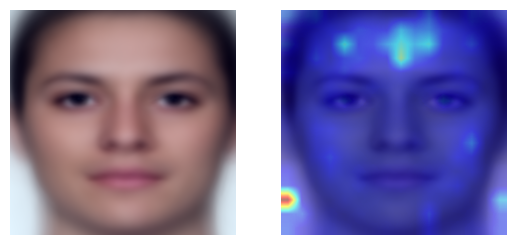

In [76]:
morphing_prompts = [template.format("face image morphing attack") for template in templates_appearance]
bonafide_prompts = [template.format("bona-fide presentation") for template in templates_appearance]

texts = morphing_prompts + bonafide_prompts
text = clip.tokenize(texts).to(device)

heatmap_norms, diff_value = get_average_heatmaps(root_folder + extra_folder, text, is_multiple_prompts=True)
print("Morphing norm: ", heatmap_norms[0].item())
print("Bonafide norm: ", heatmap_norms[1].item())
print("Heatmap differences: ", diff_value)

Morphing norm:  57.943302154541016
Bonafide norm:  19.963838577270508
Heatmap differences:  0.037401874


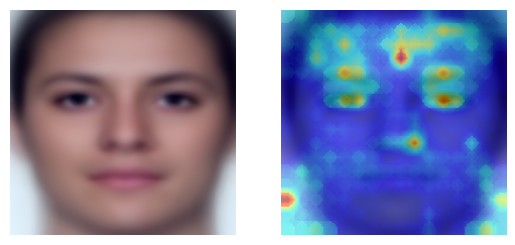

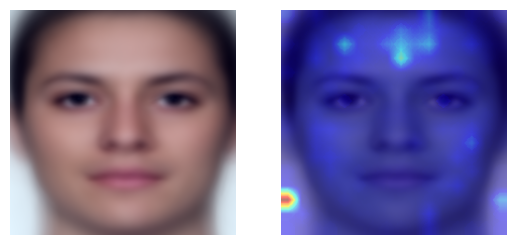

In [77]:
morphing_prompts = [template.format("face image morphing attack") for template in templates_id_pr]
bonafide_prompts = [template.format("bona-fide presentation") for template in templates_id_pr]

texts = morphing_prompts + bonafide_prompts
text = clip.tokenize(texts).to(device)

heatmap_norms, diff_value = get_average_heatmaps(root_folder + extra_folder, text, is_multiple_prompts=True)
print("Morphing norm: ", heatmap_norms[0].item())
print("Bonafide norm: ", heatmap_norms[1].item())
print("Heatmap differences: ", diff_value)

Morphing norm:  67.96172332763672
Bonafide norm:  22.44904136657715
Heatmap differences:  0.05143844


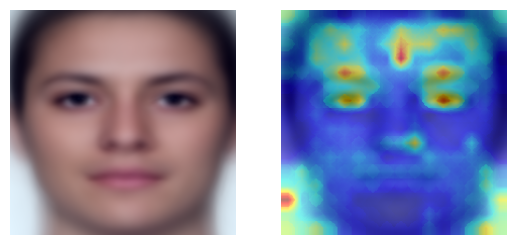

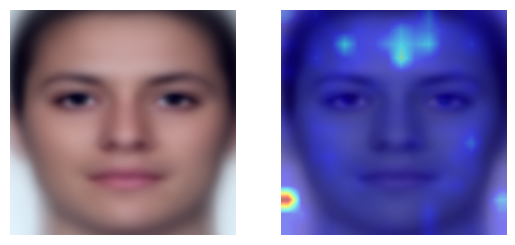

In [78]:
morphing_prompts = [template.format("face image morphing attack") for template in templates_id_ap]
bonafide_prompts = [template.format("bona-fide presentation") for template in templates_id_ap]

texts = morphing_prompts + bonafide_prompts
text = clip.tokenize(texts).to(device)

heatmap_norms, diff_value = get_average_heatmaps(root_folder + extra_folder, text, is_multiple_prompts=True)
print("Morphing norm: ", heatmap_norms[0].item())
print("Bonafide norm: ", heatmap_norms[1].item())
print("Heatmap differences: ", diff_value)

Morphing norm:  64.00452423095703
Bonafide norm:  22.664705276489258
Heatmap differences:  0.042413358


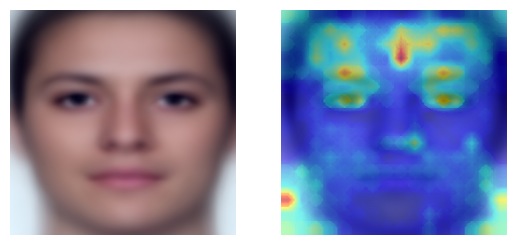

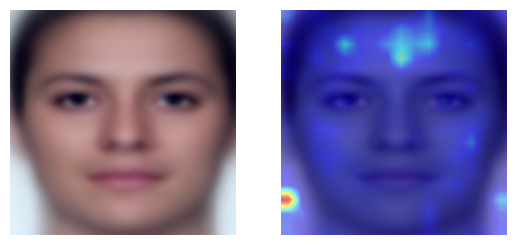

In [79]:
morphing_prompts = [template.format("face image morphing attack") for template in templates_pr_ap]
bonafide_prompts = [template.format("bona-fide presentation") for template in templates_pr_ap]

texts = morphing_prompts + bonafide_prompts
text = clip.tokenize(texts).to(device)

heatmap_norms, diff_value = get_average_heatmaps(root_folder + extra_folder, text, is_multiple_prompts=True)
print("Morphing norm: ", heatmap_norms[0].item())
print("Bonafide norm: ", heatmap_norms[1].item())
print("Heatmap differences: ", diff_value)

Morphing norm:  64.57124328613281
Bonafide norm:  21.437938690185547
Heatmap differences:  0.046520773


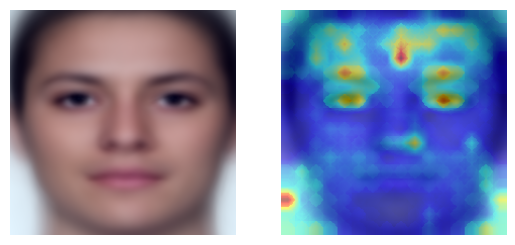

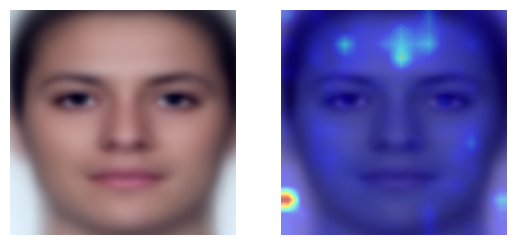

In [80]:
morphing_prompts = [template.format("face image morphing attack") for template in templates_all]
bonafide_prompts = [template.format("bona-fide presentation") for template in templates_all]

texts = morphing_prompts + bonafide_prompts
text = clip.tokenize(texts).to(device)

heatmap_norms, diff_value = get_average_heatmaps(root_folder + extra_folder, text, is_multiple_prompts=True)
print("Morphing norm: ", heatmap_norms[0].item())
print("Bonafide norm: ", heatmap_norms[1].item())
print("Heatmap differences: ", diff_value)